# Лабораторная работа 7. Детекция объектов с помощью сверточных нейронных сетей

### Работу выполнил:<span style="color:blue"> {Иззатов Эльшан}</span>

** ССЫЛКА НА ВИДЕО ПОСЛЕДНЕЕ ЗАДАНИЕ**

https://drive.google.com/file/d/1XtJ4Bor3B_9sg6pQRGyoqiEAFrxY_HLE/view?usp=sharing

### Сделанную лабораторную работу отправляйте через [ФОРМУ](https://vyatsu-my.sharepoint.com/:f:/g/personal/usr09019_vyatsu_ru/EqIJYrpQGKNAlYCYc9d54aUBmjBEhPTP3tn5ctj9Zfx5wA)

## Задание 1.
По [ссылке1](https://github.com/spmallick/learnopencv/tree/master/PyTorch-faster-RCNN) приведен пример детекции объектов сетью Faster R-CNN с использованием PyTorch.

По [ссылке2](https://pytorch.org/hub/ultralytics_yolov5/) приведен пример детекции объектов сетью YOLOv5 с использованием PyTorch.

Необходимо выполнить сравнение моделей детекции объектов Faster R-CNN ResNet-50 FPN, RetinaNet ResNet-50 FPN, YOLOv5 по следующим параметрам:
1. время инференса на GPU;
2. время инференса на CPU;
3. размер модели.

Результаты сравнения представить в виде диаграмм.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
test_image_path = "/content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_7/test.jpg"

In [3]:
# Устанавливаем необходимые зависимости
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.4 MB/s eta 0:00:00


In [18]:
%matplotlib inline

In [4]:
import torch
import torchvision
import time
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as T

In [5]:
def load_all_models():
    """
    Загрузка всех моделей детекции:
    - Faster R-CNN ResNet-50 FPN
    - RetinaNet ResNet-50 FPN
    - YOLOv5s
    """
    print("Загрузка моделей для сравнения...")

    models = {}

    # Faster R-CNN с использованием современного синтаксиса weights
    models['faster_rcnn'] = torchvision.models.detection.fasterrcnn_resnet50_fpn(
        weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1
    )

    # RetinaNet с использованием современного синтаксиса weights
    models['retinanet'] = torchvision.models.detection.retinanet_resnet50_fpn(
        weights=torchvision.models.detection.RetinaNet_ResNet50_FPN_Weights.COCO_V1
    )

    # YOLOv5s из torch.hub
    models['yolov5'] = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

    # Переводим модели в режим оценки (не обучение)
    for name in ['faster_rcnn', 'retinanet']:
        models[name].eval()

    print("Все модели успешно загружены!")
    return models

models = load_all_models()


Загрузка моделей для сравнения...
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:01<00:00, 139MB/s]


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


100%|██████████| 130M/130M [00:01<00:00, 93.6MB/s]
/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-11-2 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 179MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Все модели успешно загружены!


In [6]:
def get_model_sizes(models):
    """
    Измерение размера каждой модели в мегабайтах
    """
    print("\n--- Измерение размеров моделей ---")
    model_sizes = {}

    for name, model in models.items():
        # Временно сохраняем веса модели для измерения размера файла
        torch.save(model.state_dict(), "temp.p")
        size_mb = os.path.getsize("temp.p") / (1024 * 1024)
        os.remove("temp.p")

        model_sizes[name] = size_mb
        print(f"{name}: {size_mb:.2f} MB")

    return model_sizes

model_sizes = get_model_sizes(models)


--- Измерение размеров моделей ---
faster_rcnn: 159.77 MB
retinanet: 130.24 MB
yolov5: 27.61 MB


In [7]:
def measure_inference_time(models, image_path, device='cpu', num_runs=5):
    """
    Измерение среднего времени инференса для всех моделей на указанном устройстве
    """
    print(f"\n--- Измерение времени инференса на {device.upper()} ---")

    # Загрузка и преобразование изображения
    img = Image.open(image_path)
    transform = T.Compose([T.ToTensor()])
    img_tensor = transform(img)

    inference_times = {}

    for model_name, model in models.items():
        print(f"Тестирование {model_name}...")

        try:
            # Подготовка модели и данных для конкретного устройства
            if model_name != 'yolov5':
                model_device = model.to(device)
                input_data = img_tensor.to(device)
            else:
                # YOLOv5 имеет свой собственный формат ввода
                model_device = model.to(device)
                input_data = image_path  # YOLOv5 принимает путь к изображению

            # Прогрев модели (первый запуск)
            if model_name != 'yolov5':
                _ = model_device([input_data])
            else:
                _ = model_device(input_data)

            # Измерение времени на нескольких запусках
            start_time = time.time()
            for _ in range(num_runs):
                if model_name != 'yolov5':
                    _ = model_device([input_data])
                else:
                    _ = model_device(input_data)
            end_time = time.time()

            # Расчет среднего времени
            avg_time = (end_time - start_time) / num_runs
            inference_times[model_name] = avg_time
            print(f"{model_name}: {avg_time:.4f} сек")

        except Exception as e:
            print(f"Ошибка при тестировании {model_name}: {e}")
            inference_times[model_name] = float('inf')

    return inference_times

In [8]:
#Измерение времени инференса на CPU
cpu_times = measure_inference_time(models, test_image_path, device='cpu')


--- Измерение времени инференса на CPU ---
Тестирование faster_rcnn...
faster_rcnn: 7.1621 сек
Тестирование retinanet...
retinanet: 6.6617 сек
Тестирование yolov5...


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.am

yolov5: 0.2433 сек


In [9]:
#Измерение времени инференса на GPU (если доступно)
gpu_times = {}
if torch.cuda.is_available():
    gpu_times = measure_inference_time(models, test_image_path, device='cuda')
else:
    print("\nGPU не доступен для тестирования")


--- Измерение времени инференса на CUDA ---
Тестирование faster_rcnn...
faster_rcnn: 0.1043 сек
Тестирование retinanet...
retinanet: 0.1099 сек
Тестирование yolov5...
yolov5: 0.0286 сек


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.am

In [19]:
def create_comparison_charts(model_sizes, cpu_times, gpu_times):
    """
    Создание диаграмм для визуального сравнения моделей по всем параметрам
    """
    print("\n--- Построение диаграмм сравнения ---")

    # Проверяем, что есть данные для CPU
    if not model_sizes or not cpu_times:
        print("Нет данных для построения диаграмм.")
        return

    # Определяем общие модели для CPU и размеров
    common_models = [model for model in model_sizes if model in cpu_times]
    if not common_models:
        print("Нет общих моделей для построения диаграмм.")
        return

    # Создаем фигуру с 4 подграфиками
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Сравнение моделей детекции объектов', fontsize=16, fontweight='bold')

    # Диаграмма 1: Размеры моделей
    sizes = [model_sizes[model] for model in common_models]

    bars1 = axes[0, 0].bar(common_models, sizes, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
    axes[0, 0].set_title('Размеры моделей', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Размер (MB)', fontsize=12)
    axes[0, 0].grid(axis='y', alpha=0.3)

    # Добавляем числовые значения на столбцы
    for bar, value in zip(bars1, sizes):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                       f'{value:.1f} MB', ha='center', va='bottom', fontweight='bold')

    # Диаграмма 2: Время инференса на CPU
    cpu_values = [cpu_times[model] for model in common_models]
    bars2 = axes[0, 1].bar(common_models, cpu_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
    axes[0, 1].set_title('Время инференса на CPU', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Время (сек)', fontsize=12)
    axes[0, 1].grid(axis='y', alpha=0.3)

    for bar, value in zip(bars2, cpu_values):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{value:.3f} с', ha='center', va='bottom', fontweight='bold')

    # Диаграмма 3: Время инференса на GPU (если доступно)
    if gpu_times:
        # Берем только те модели, для которых есть GPU данные
        gpu_models = [model for model in common_models if model in gpu_times]
        gpu_values = [gpu_times[model] for model in gpu_models]

        if gpu_models:
            bars3 = axes[1, 0].bar(gpu_models, gpu_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
            axes[1, 0].set_title('Время инференса на GPU', fontsize=14, fontweight='bold')
            axes[1, 0].set_ylabel('Время (сек)', fontsize=12)
            axes[1, 0].grid(axis='y', alpha=0.3)

            for bar, value in zip(bars3, gpu_values):
                axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                               f'{value:.4f} с', ha='center', va='bottom', fontweight='bold')
        else:
            axes[1, 0].text(0.5, 0.5, 'Нет данных по GPU для общих моделей', ha='center', va='center',
                           transform=axes[1, 0].transAxes, fontsize=12)
            axes[1, 0].set_title('Время инференса на GPU', fontsize=14, fontweight='bold')
    else:
        axes[1, 0].text(0.5, 0.5, 'GPU не доступен', ha='center', va='center',
                       transform=axes[1, 0].transAxes, fontsize=16)
        axes[1, 0].set_title('Время инференса на GPU', fontsize=14, fontweight='bold')

    # Диаграмма 4: Сравнение CPU vs GPU
    if gpu_times:
        # Модели, для которых есть и CPU и GPU данные
        comparison_models = [model for model in common_models if model in gpu_times]
        if comparison_models:
            cpu_comp = [cpu_times[model] for model in comparison_models]
            gpu_comp = [gpu_times[model] for model in comparison_models]

            x = np.arange(len(comparison_models))
            width = 0.35

            bars_cpu = axes[1, 1].bar(x - width/2, cpu_comp, width, label='CPU', color='#FF6B6B', alpha=0.8)
            bars_gpu = axes[1, 1].bar(x + width/2, gpu_comp, width, label='GPU', color='#4ECDC4', alpha=0.8)

            axes[1, 1].set_title('Сравнение CPU vs GPU', fontsize=14, fontweight='bold')
            axes[1, 1].set_ylabel('Время (сек)', fontsize=12)
            axes[1, 1].set_xticks(x)
            axes[1, 1].set_xticklabels(comparison_models)
            axes[1, 1].legend()
            axes[1, 1].grid(axis='y', alpha=0.3)

            # Добавляем значения на столбцы
            for bar, value in zip(bars_cpu, cpu_comp):
                axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                               f'{value:.3f} с', ha='center', va='bottom', fontsize=9, fontweight='bold')

            for bar, value in zip(bars_gpu, gpu_comp):
                axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                               f'{value:.4f} с', ha='center', va='bottom', fontsize=9, fontweight='bold')
        else:
            axes[1, 1].text(0.5, 0.5, 'Нет общих моделей для сравнения CPU/GPU', ha='center', va='center',
                           transform=axes[1, 1].transAxes, fontsize=12)
            axes[1, 1].set_title('Сравнение CPU vs GPU', fontsize=14, fontweight='bold')
    else:
        axes[1, 1].text(0.5, 0.5, 'Нет данных GPU\nдля сравнения', ha='center', va='center',
                       transform=axes[1, 1].transAxes, fontsize=16)
        axes[1, 1].set_title('Сравнение CPU vs GPU', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()


--- Построение диаграмм сравнения ---


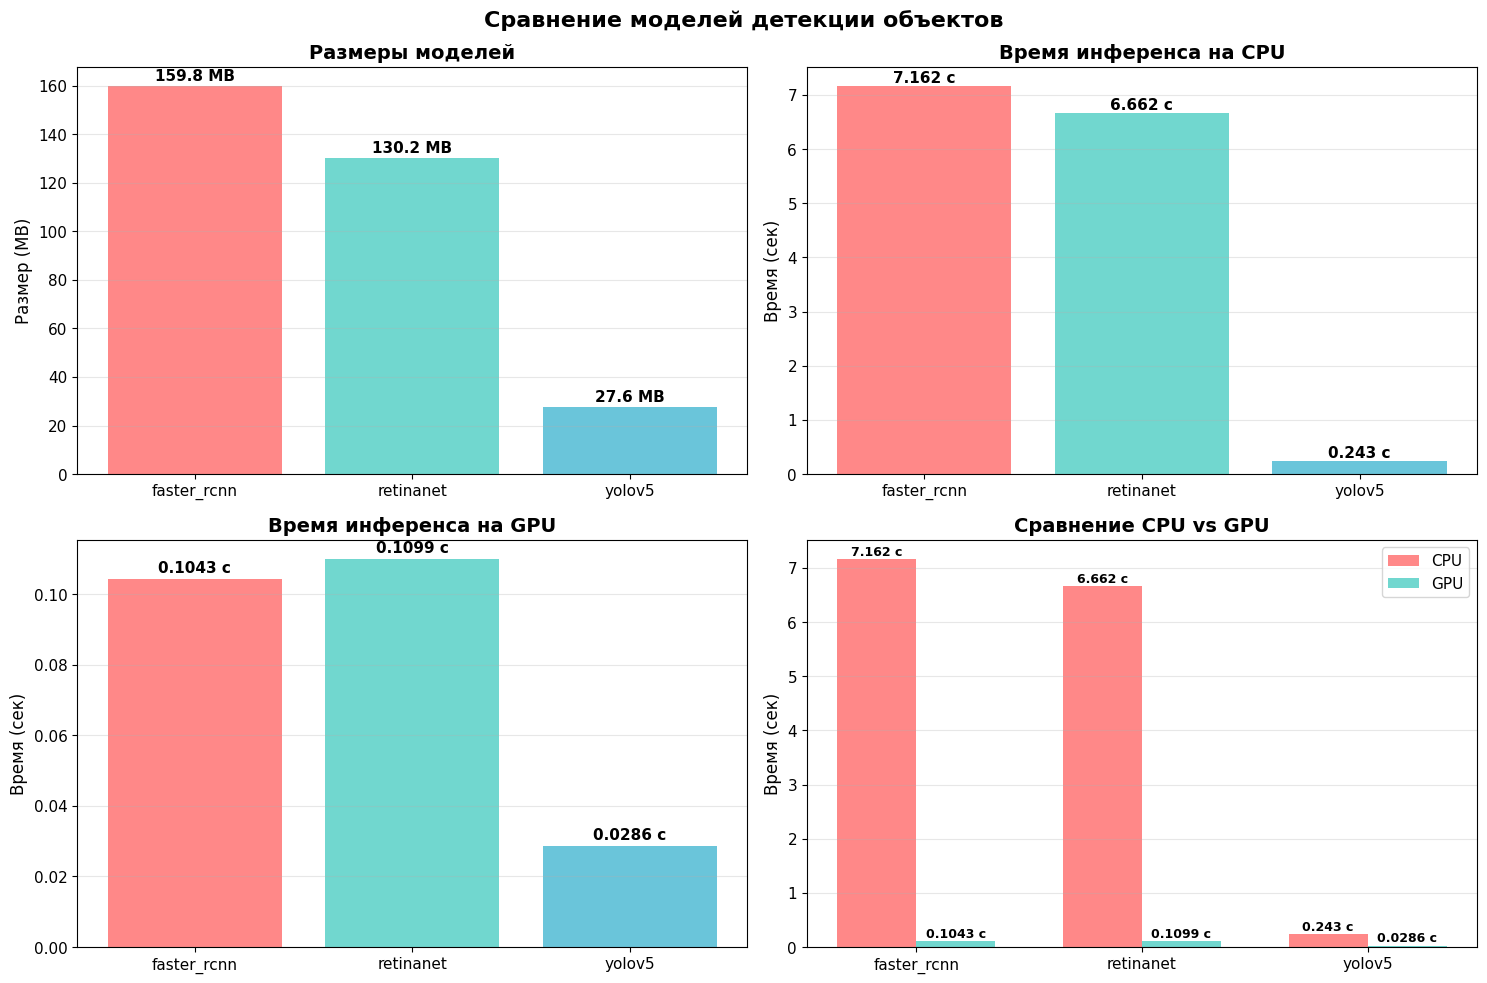

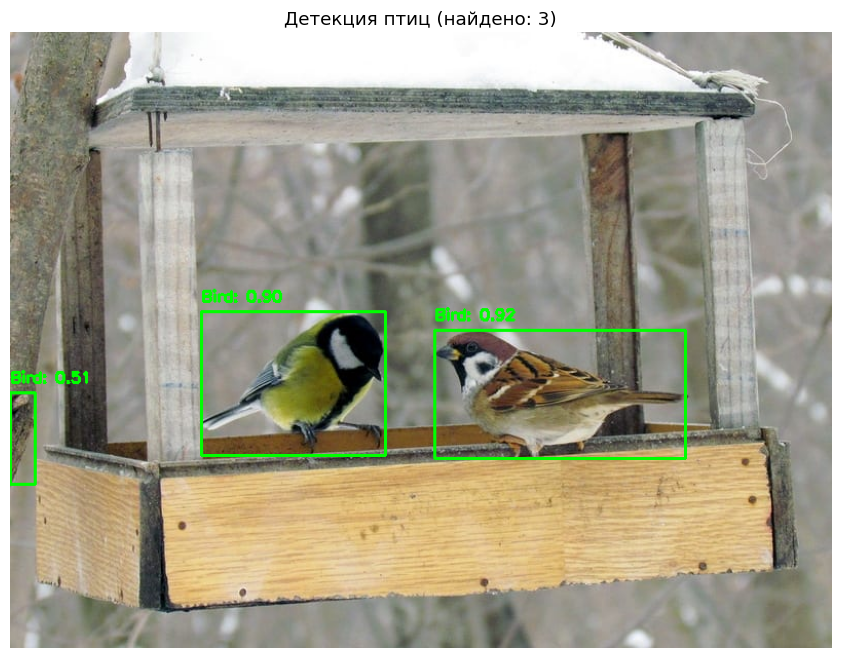

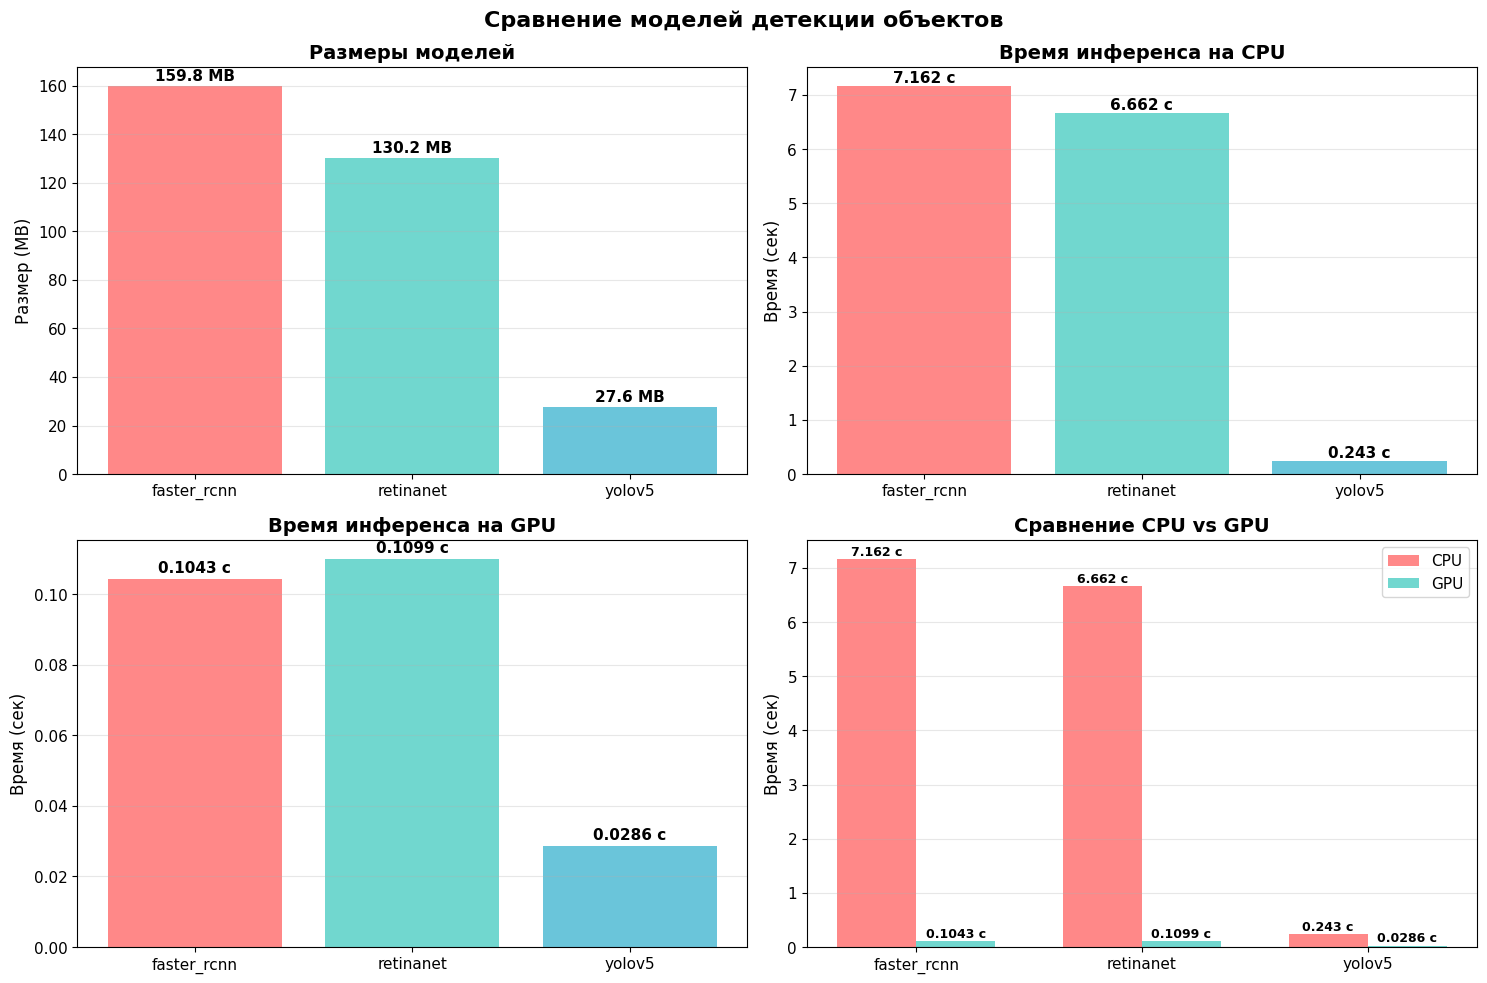

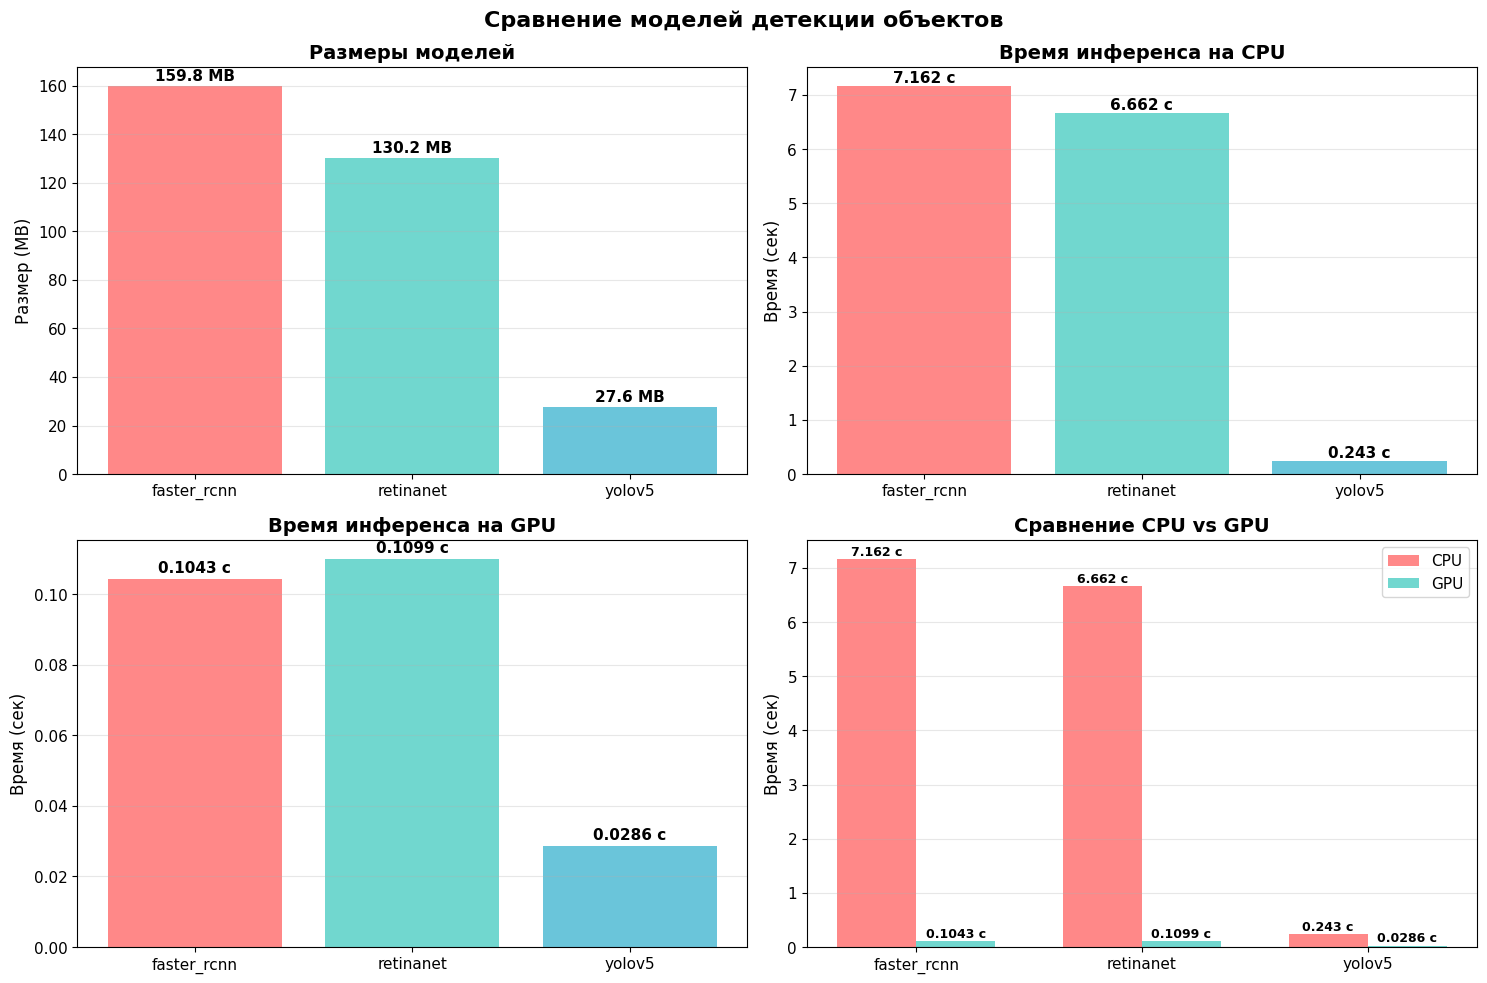

In [20]:
create_comparison_charts(model_sizes, cpu_times, gpu_times)

In [12]:
def analyze_results(model_sizes, cpu_times, gpu_times):
    """
    Детальный анализ и вывод результатов сравнения в текстовом виде
    """
    print("\n" + "="*60)
    print("ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ")
    print("="*60)

    # Определение лучших моделей по каждому параметру
    best_cpu_model = min(cpu_times, key=cpu_times.get)
    best_cpu_time = cpu_times[best_cpu_model]

    smallest_model = min(model_sizes, key=model_sizes.get)
    smallest_size = model_sizes[smallest_model]

    print(f"Самая быстрая модель на CPU: {best_cpu_model} ({best_cpu_time:.4f} сек)")
    print(f"Самая компактная модель: {smallest_model} ({smallest_size:.2f} MB)")

    if gpu_times:
        best_gpu_model = min(gpu_times, key=gpu_times.get)
        best_gpu_time = gpu_times[best_gpu_model]
        print(f"Самая быстрая модель на GPU: {best_gpu_model} ({best_gpu_time:.4f} сек)")

        # Расчет ускорения на GPU
        print("\nУскорение на GPU по сравнению с CPU:")
        for model in gpu_times:
            if model in cpu_times:
                speedup = cpu_times[model] / gpu_times[model]
                print(f"  {model}: {speedup:.2f}x")

    # Сводная таблица результатов
    print("\n" + "-" * 70)
    print(f"{'Модель':<15} {'Размер (MB)':<12} {'CPU время (с)':<15} {'GPU время (с)':<15}")
    print("-" * 70)

    for model in cpu_times.keys():
        size = model_sizes.get(model, "N/A")
        cpu_time = cpu_times[model]
        gpu_time = gpu_times.get(model, "N/A")

        if gpu_time != "N/A":
            gpu_str = f"{gpu_time:.4f}"
        else:
            gpu_str = "N/A"

        print(f"{model:<15} {size:<12.2f} {cpu_time:<15.4f} {gpu_str:<15}")

In [13]:
analyze_results(model_sizes, cpu_times, gpu_times)


ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ
Самая быстрая модель на CPU: yolov5 (0.2433 сек)
Самая компактная модель: yolov5 (27.61 MB)
Самая быстрая модель на GPU: yolov5 (0.0286 сек)

Ускорение на GPU по сравнению с CPU:
  faster_rcnn: 68.68x
  retinanet: 60.63x
  yolov5: 8.51x

----------------------------------------------------------------------
Модель          Размер (MB)  CPU время (с)   GPU время (с)  
----------------------------------------------------------------------
faster_rcnn     159.77       7.1621          0.1043         
retinanet       130.24       6.6617          0.1099         
yolov5          27.61        0.2433          0.0286         


## Задание 2.
Выберите наиболее эффективную архетиктуру из рассмотренных в задании 1. Протестируйте данную архитектуру на задаче детекции птиц на фотографиях.
Протестируйте эту модель на нескольких изображениях (определять нужно только птиц).
Используйте данную модель для трекинга птиц на видео (в качестве детектора используйте нейросетевую модель, в качестве трекера - трекер MIL из OpenCV).

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-11-2 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


=== ДЕТЕКЦИЯ ПТИЦ НА ИЗОБРАЖЕНИИ ===
Тестовое изображение: /content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_7/test.jpg
Найдено птиц: 3

Детали обнаружений:
Птица 1: confidence=0.921, bbox=[413.1, 290.2, 657.6, 415.3]
Птица 2: confidence=0.903, bbox=[186.1, 272.4, 365.8, 412.4]
Птица 3: confidence=0.511, bbox=[0.0, 351.8, 25.0, 441.0]


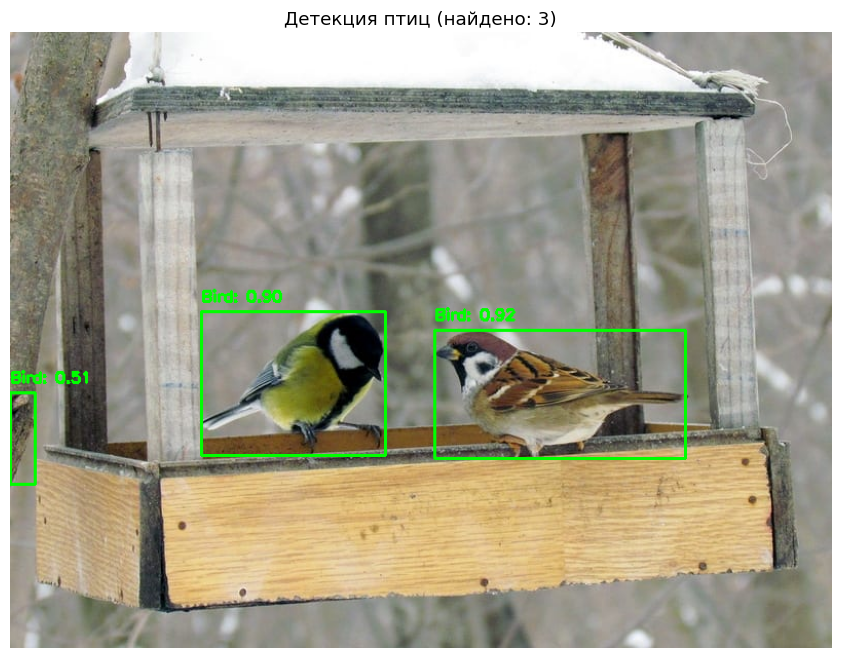

In [21]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Загрузка предобученной модели YOLOv5 (YOLOv5s - самая быстрая и легкая)
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Функция для детекции птиц на изображении
def detect_birds_image(image_path, confidence_threshold=0.5):
    """
    Детекция птиц на изображении с использованием YOLOv5
    """
    # Загрузка и детекция
    results = model(image_path)

    # Извлечение результатов в формате pandas
    detections = results.pandas().xyxy[0]

    # Фильтрация только птиц (class_id = 14 в COCO) с достаточной уверенностью
    bird_detections = detections[(detections['class'] == 14) &
                                (detections['confidence'] > confidence_threshold)]

    return bird_detections, results

# Функция для визуализации результатов детекции
def visualize_detection(image_path, detections, save_path=None):
    """
    Визуализация bounding boxes на изображении
    """
    # Загрузка изображения
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Отрисовка bounding boxes для каждого обнаружения
    for _, detection in detections.iterrows():
        x1, y1, x2, y2 = int(detection['xmin']), int(detection['ymin']), \
                         int(detection['xmax']), int(detection['ymax'])
        confidence = detection['confidence']

        # Рисование прямоугольника
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Добавление подписи с уверенностью
        label = f'Bird: {confidence:.2f}'
        cv2.putText(img, label, (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Отображение результата
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Детекция птиц (найдено: {len(detections)})')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

# Основной код для детекции на изображении
def main_image_detection():
    # Путь к тестовому изображению из Google Drive
    test_image_path = "/content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_7/test.jpg"

    print("=== ДЕТЕКЦИЯ ПТИЦ НА ИЗОБРАЖЕНИИ ===")
    print(f"Тестовое изображение: {test_image_path}")

    # Детекция птиц
    bird_detections, results = detect_birds_image(test_image_path, confidence_threshold=0.5)

    # Вывод результатов
    print(f"Найдено птиц: {len(bird_detections)}")
    if len(bird_detections) > 0:
        print("\nДетали обнаружений:")
        for i, (_, detection) in enumerate(bird_detections.iterrows()):
            print(f"Птица {i+1}: confidence={detection['confidence']:.3f}, "
                  f"bbox=[{detection['xmin']:.1f}, {detection['ymin']:.1f}, "
                  f"{detection['xmax']:.1f}, {detection['ymax']:.1f}]")

    # Визуализация результатов
    visualize_detection(test_image_path, bird_detections, "bird_detection_result.jpg")

    return bird_detections, results

# Запуск детекции на изображении
image_detections, image_results = main_image_detection()


In [25]:
import torch
import cv2
import numpy as np
import time
import warnings

# Подавляем предупреждения
warnings.filterwarnings('ignore', category=FutureWarning)

# Загрузка модели YOLOv5
print("Загрузка модели YOLOv5...")
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
print("Модель YOLOv5 успешно загружена!")

def detect_birds_frame(frame, confidence_threshold=0.3):
    """
    Детекция птиц на одном кадре видео
    """
    # Конвертация BGR в RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Детекция с помощью YOLOv5
    results = model(frame_rgb)
    detections = results.pandas().xyxy[0]

    # Фильтрация птиц
    bird_detections = detections[(detections['class'] == 14) &
                                (detections['confidence'] > confidence_threshold)]

    # Конвертация в формат (x, y, w, h) для трекера
    bboxes = []
    for _, detection in bird_detections.iterrows():
        x1 = int(detection['xmin'])
        y1 = int(detection['ymin'])
        x2 = int(detection['xmax'])
        y2 = int(detection['ymax'])

        # Проверяем что bounding box достаточно большой и находится в пределах кадра
        w = x2 - x1
        h = y2 - y1
        if w > 30 and h > 30 and x1 >= 0 and y1 >= 0 and x2 <= frame.shape[1] and y2 <= frame.shape[0]:
            bboxes.append((x1, y1, w, h))

    return bboxes, bird_detections

# Параметры видео
video_path = "/content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_7/video.avi"
output_path = "/content/drive/MyDrive/Computer_vision/CV_labs/CV_lab_7/birds_tracking_result.avi"

print("Загрузка видео...")
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"Ошибка: не удалось открыть видео {video_path}")
else:
    # Получение параметров видео
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Ограничение до 2 минут (120 секунд)
    max_frames = int(fps * 120)

    print(f"Параметры видео: {width}x{height}, FPS: {fps:.1f}")
    print(f"Обработка первых 2 минут ({max_frames} кадров)")

    # Создание VideoWriter для сохранения результата
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Инициализация трекеров
    trackers = []
    bird_ids = []
    next_id = 1

    # Цвета для разных трекеров
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0),
              (255, 0, 255), (0, 255, 255), (128, 0, 128), (255, 165, 0)]

    frame_count = 0
    start_time = time.time()

    print("Начинаем обработку видео...")

    while frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        # Периодическая детекция (каждые 10 кадров)
        if frame_count % 10 == 0 or len(trackers) == 0:
            # Детекция птиц на текущем кадре
            new_bboxes, detections = detect_birds_frame(frame, confidence_threshold=0.3)

            if len(new_bboxes) > 0:
                print(f"Обнаружено птиц: {len(new_bboxes)}")

            # Создание новых трекеров для обнаруженных птиц
            for bbox in new_bboxes:
                x, y, w, h = bbox

                # Проверяем, не пересекается ли новый bbox с существующими трекерами
                overlap = False
                for tracker, bird_id in zip(trackers, bird_ids):
                    ok, existing_bbox = tracker.update(frame)
                    if ok:
                        ex, ey, ew, eh = [int(v) for v in existing_bbox]
                        # Простая проверка пересечения
                        if (x < ex + ew and x + w > ex and
                            y < ey + eh and y + h > ey):
                            overlap = True
                            break

                if not overlap:
                    # Попробуем разные трекеры по очереди
                    tracker = None

                    # Сначала попробуем CSRT (самый точный)
                    tracker = cv2.TrackerCSRT_create()
                    success = tracker.init(frame, bbox)

                    if not success:
                        # Если CSRT не сработал, попробуем KCF
                        tracker = cv2.TrackerKCF_create()
                        success = tracker.init(frame, bbox)

                    if not success:
                        # Если KCF не сработал, попробуем MOSSE (самый быстрый)
                        tracker = cv2.TrackerMOSSE_create()
                        success = tracker.init(frame, bbox)

                    if success and tracker is not None:
                        trackers.append(tracker)
                        bird_ids.append(next_id)
                        print(f"Создан трекер для птицы ID: {next_id} с bbox: {bbox}")
                        next_id += 1
                    else:
                        print(f"Не удалось инициализировать трекер для bbox: {bbox}")

        # Обновление существующих трекеров
        active_trackers = []
        active_ids = []

        for i, (tracker, bird_id) in enumerate(zip(trackers, bird_ids)):
            # Обновление трекера
            ok, bbox = tracker.update(frame)

            if ok:
                # Трекер успешно обновился - рисуем bounding box
                x, y, w, h = [int(v) for v in bbox]
                color = colors[bird_id % len(colors)]

                # Рисование прямоугольника
                cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)

                # Добавление ID птицы
                cv2.putText(frame, f"Bird {bird_id}",
                           (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

                active_trackers.append(tracker)
                active_ids.append(bird_id)
            else:
                # Трекер потерял объект
                print(f"Трекер для птицы ID: {bird_id} потерял объект")

        # Обновление списков трекеров
        trackers = active_trackers
        bird_ids = active_ids

        # Добавление информации о кадре
        cv2.putText(frame, f"Frame: {frame_count}", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(frame, f"Active trackers: {len(trackers)}", (10, 60),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        # Сохранение кадра
        out.write(frame)

        # Показ прогресса
        if frame_count % 50 == 0:
            elapsed = time.time() - start_time
            print(f"Обработано кадров: {frame_count}/{max_frames} "
                  f"({frame_count/max_frames*100:.1f}%), "
                  f"Активных трекеров: {len(trackers)}")

    # Завершение работы
    cap.release()
    out.release()

    total_time = time.time() - start_time
    print(f"\nОбработка завершена!")
    print(f"Обработано кадров: {frame_count}")
    print(f"Общее время: {total_time:.2f} сек")
    print(f"Скорость обработки: {frame_count/total_time:.2f} FPS")
    print(f"Максимальное количество трекеров: {next_id-1}")
    print(f"Результат сохранен в: {output_path}")

Загрузка модели YOLOv5...


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-11-2 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Модель YOLOv5 успешно загружена!
Загрузка видео...
Параметры видео: 1280x720, FPS: 25.0
Обработка первых 2 минут (3000 кадров)
Начинаем обработку видео...
Обработано кадров: 50/3000 (1.7%), Активных трекеров: 0
Обработано кадров: 100/3000 (3.3%), Активных трекеров: 0
Обработано кадров: 150/3000 (5.0%), Активных трекеров: 0
Обработано кадров: 200/3000 (6.7%), Активных трекеров: 0
Обработано кадров: 250/3000 (8.3%), Активных трекеров: 0
Обработано кадров: 300/3000 (10.0%), Активных трекеров: 0
Обработано кадров: 350/3000 (11.7%), Активных трекеров: 0
Обработано кадров: 400/3000 (13.3%), Активных трекеров: 0
Обработано кадров: 450/3000 (15.0%), Активных трекеров: 0
Обработано кадров: 500/3000 (16.7%), Активных трекеров: 0
Обработано кадров: 550/3000 (18.3%), Активных трекеров: 0
Обработано кадров: 600/3000 (20.0%), Активных трекеров: 0
Обработано кадров: 650/3000 (21.7%), Активных трекеров: 0
Обработано кадров: 700/3000 (23.3%), Активных трекеров: 0
Обнаружено птиц: 1


AttributeError: module 'cv2' has no attribute 'TrackerMOSSE_create'